# 1. Giới thiệu: 
Meta Prophet là một mô hình  được phát triển bởi đội ngũ Facebook (Meta hiện nay).

Prophet là một mô hình chuyên xử lý bài toán Time Series Forecasting được phát triển bởi Facebook, đặc biệt phù hợp với dữ liệu có tính chu kỳ mạnh theo ngày, tuần, năm và có xu hướng biến động theo mùa. Prophet được thiết kế để dễ sử dụng, linh hoạt, và hoạt động tốt với cả dữ liệu thiếu hoặc có các điểm bất thường (outliers).

Mô hình này dựa trên phương pháp additive model hoặc multiplicative model, trong đó tín hiệu chuỗi thời gian được tách thành ba thành phần chính:
<ul>
    <li>Trend (xu hướng tổng thể)</li>
    <li>Seasonality (tính mùa vụ: ngày, tuần, năm)</li>
    <li>Holiday effects (ảnh hưởng của ngày lễ, nếu có cung cấp).</li>
</ul>

Prophet hỗ trợ dự báo tương lai bằng cách mở rộng khung thời gian và trả về dự báo cùng khoảng tin cậy, rất hữu ích trong các ứng dụng thực tiễn như dự đoán sản lượng điện, doanh thu, lưu lượng truy cập, v.v.

# 2. Chuẩn bị dữ liệu:
<p>Việc sử dụng mô hình Prophet rất đơn giản, dữ liệu cần chuẩn bị là 1 DataFrame với 2 cột được đặt tên theo quy ước: 
    <ul>
        <li>'ds' : input thời gian (datetime)</li>
        <li>'y' : output cần dự đoán (model sẽ fit theo giá trị này)</li>
    </ul>
</p>

<p>
    Tuy nhiên, khi thực hiện predict, prophet sẽ trả ra nhiều thông số hơn ngoài giá trị cần tính toán. Các thông số này là các xu hướng biến động của dữ liệu theo các tần số khác nhau... Nhằm phục vụ nghiên cứu sâu hơn về bộ dữ liệu.
</p>

<p>
    <h5>=> Vậy ta sẽ cần chuẩn bị những gì?</h5>
    Riêng đối với mô hình này, ta sẽ bỏ qua tiền xử lý, tiến hành huấn luyện và visualize luôn.
    Các hàm được định nghĩa phía dưới sẽ thực hiện tách các tập dữ liệu, cũng như phục vụ visualize.
</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [3]:
# Lấy trung bình các dòng bị lặp
def mean_duplicate_rows(df) :
    duplicate = df[df.index.duplicated(keep=False)]
    dup_mean = duplicate.groupby(level=0).mean(numeric_only=True)

    df.drop(index=duplicate.index, inplace=True)

    df_meaned = pd.concat([df, dup_mean])

    df_meaned = df_meaned.resample('h').mean()  # Lấy trung bình của các giờ được thu thập dữ liệu nhiều lần (vd như lẻ 15ph, 30ph)
    return df_meaned

# Nội suy các thời điểm bị thiếu
def interpolate_missing_rows(df) :
    start = df.index.min()
    end = df.index.max()
    full_range = pd.date_range(start=start, end=end, freq='h') # Tạo dải thời gian đầy đủ theo từng giờ

    missing_dates = full_range.difference(df.index)

    df_missing = pd.DataFrame(index=missing_dates, columns=df.columns)
    df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào
    
    df_full = df_full.infer_objects()
    df_full.interpolate(method='time', inplace=True)   # Nội suy cột Năng lượng ..._MW

    return df_full

fulfill_pipeline = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows))
])

Bộ dữ liệu được sử dụng

In [4]:
dataset = pd.read_csv('data/PJME_hourly.csv')

dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])
dataset.set_index('Datetime', inplace=True)
dataset.sort_index(ascending=True, inplace=True)

dataset = fulfill_pipeline.fit_transform(dataset)

C:\Users\Blade\AppData\Local\Temp\ipykernel_4864\2918201804.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào


In [5]:
train_size = int(0.7 * len(dataset))
train_data = dataset.iloc[:train_size].copy()
test_data = dataset.iloc[train_size:].copy()

Visualize

In [6]:
# Vẽ đồ thị so sánh
def plot_compare(y_test, y_predict) :
    # Tạo DataFrame từ 2 Series
    df_compare = pd.DataFrame({
        'actual': y_test,
        'predicted': y_predict
    })

    # Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    plt.plot(df_compare.index, df_compare['actual'], label='Kết quả thực', color='blue', linewidth=2)
    plt.plot(df_compare.index, df_compare['predicted'], label='Dự đoán', color='orange', linewidth=2)

    plt.title('So sánh kết quả thực và dự đoán')
    plt.ylabel('Mức tiêu thụ (MW)')
    plt.xlabel('Thời gian')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def score_compare (y_test, y_predict) :
    mae = mean_absolute_error(y_test, y_predict)
    mape = np.mean(np.abs((y_test - y_predict) / y_test)) * 100
    mse = mean_squared_error(y_test, y_predict)

    pearson, _ = pearsonr(y_test, y_predict)
    
    print(f'MAE : {mae:.2f} (~0 nghĩa là tốt hơn)')
    print(f'MAPE: {mape:.2f}% (~0 nghĩa là tốt hơn)')
    print(f'MSE : {mse:.2f} (~0 nghĩa là tốt hơn)')
    print(f'Pearson\'s r {pearson:.2f} (~1 nghĩa là phản ánh được xu hướng)')

# 3. Huấn luyện mô hình

In [8]:
import tqdm as notebook_tqdm
from prophet import Prophet

c:\Users\Blade\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
train_prophet = train_data.iloc[:, 0].copy().reset_index()  # chỉ lấy cột cần dự đoán và index là đủ

train_prophet.rename(columns={
                            'index': 'ds', 
                            train_data.columns[0]: 'y'}, 
                    inplace=True)

prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive'  # có thể thử 'additive', 'multiplicative'
)

prophet_model.fit(train_prophet)

01:02:05 - cmdstanpy - INFO - Chain [1] start processing
01:03:02 - cmdstanpy - INFO - Chain [1] done processing


## 3.1 Dự đoán lại trên tập train

In [10]:
prophet_train_predict = prophet_model.predict(train_prophet)
prophet_train_predict.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-01-01 01:00:00,29097.351196,21421.511806,30108.102473,29097.351196,29097.351196,-3291.664260,-3291.664260,-3291.664260,-4466.031075,...,1316.382941,1316.382941,1316.382941,-142.016127,-142.016127,-142.016127,0.0,0.0,0.0,25805.686936
1,2002-01-01 02:00:00,29098.121085,19852.951082,29042.648023,29098.121085,29098.121085,-4790.327557,-4790.327557,-4790.327557,-5976.464873,...,1326.691043,1326.691043,1326.691043,-140.553727,-140.553727,-140.553727,0.0,0.0,0.0,24307.793528


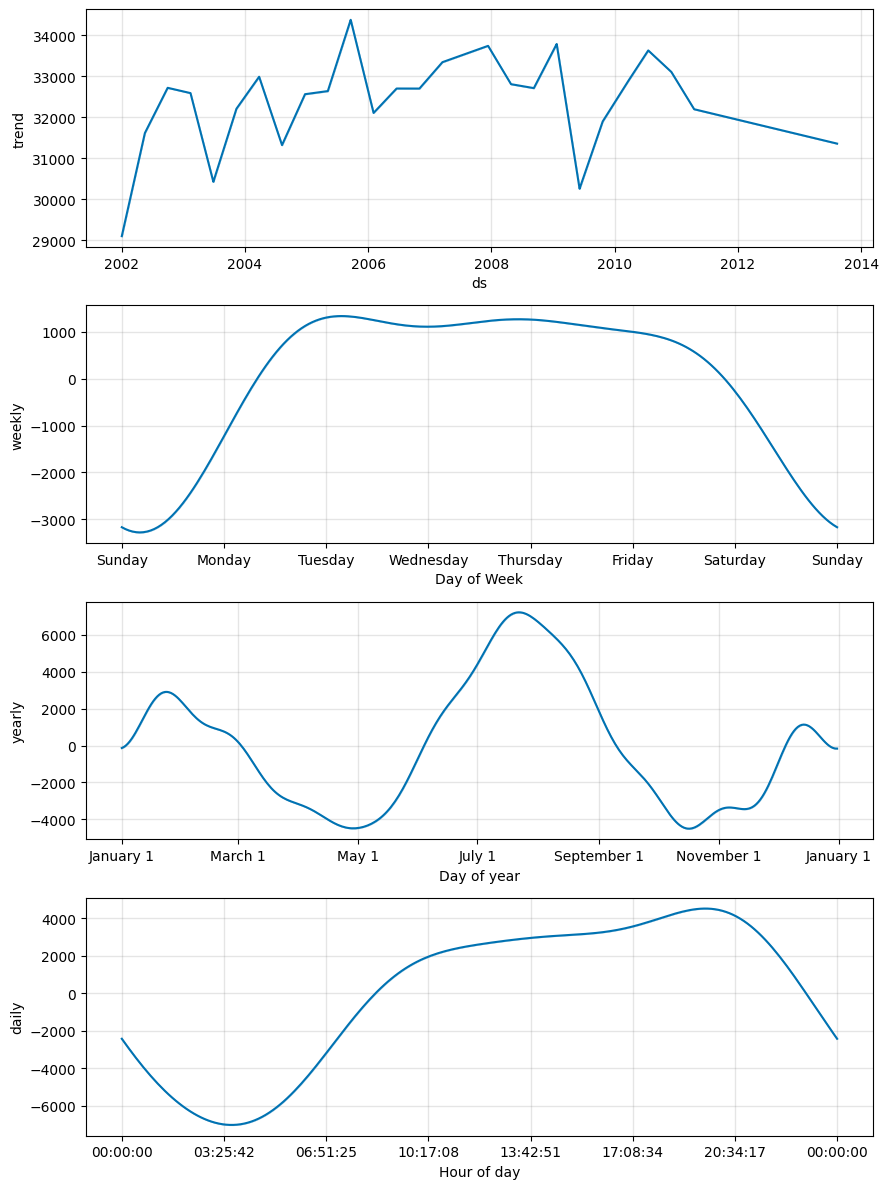

In [11]:
fig = prophet_model.plot_components(prophet_train_predict)
plt.show()

## 3.2 Dự đoán trên tập test

In [12]:
test_prophet_X = test_data.copy().reset_index()

test_prophet_X.rename(columns={
                            'index': 'ds'},
                    inplace=True)

prophet_predict = prophet_model.predict(test_prophet_X)

prophet_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43618 entries, 0 to 43617
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          43618 non-null  datetime64[ns]
 1   trend                       43618 non-null  float64       
 2   yhat_lower                  43618 non-null  float64       
 3   yhat_upper                  43618 non-null  float64       
 4   trend_lower                 43618 non-null  float64       
 5   trend_upper                 43618 non-null  float64       
 6   additive_terms              43618 non-null  float64       
 7   additive_terms_lower        43618 non-null  float64       
 8   additive_terms_upper        43618 non-null  float64       
 9   daily                       43618 non-null  float64       
 10  daily_lower                 43618 non-null  float64       
 11  daily_upper                 43618 non-null  float64   

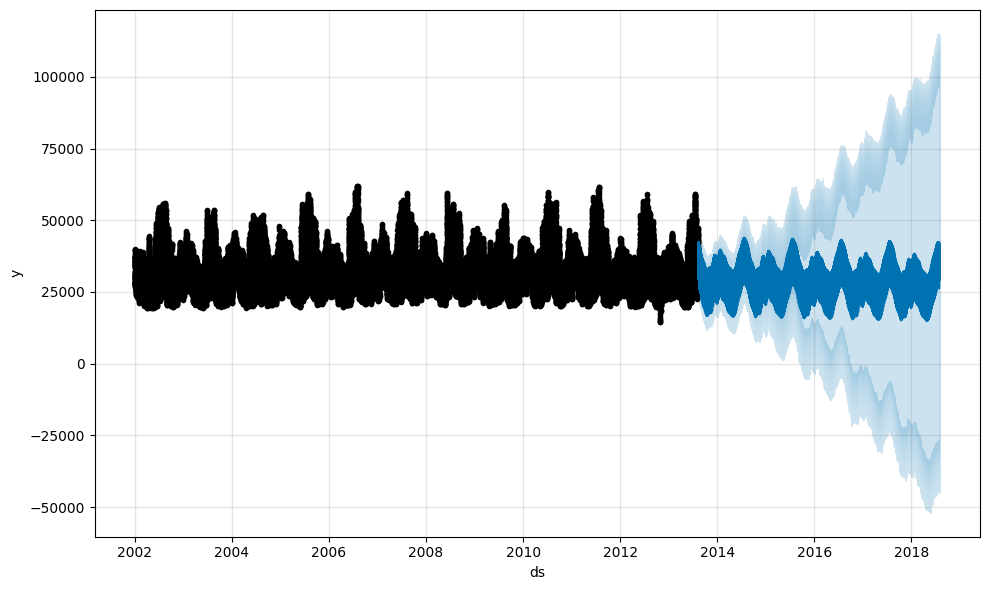

In [13]:
fig = prophet_model.plot(prophet_predict)
plt.show()

Thông số: trend
MAE : 4950.08 (~0 nghĩa là tốt hơn)
MAPE: 15.90% (~0 nghĩa là tốt hơn)
MSE : 40388865.93 (~0 nghĩa là tốt hơn)
Pearson's r 0.02 (~1 nghĩa là phản ánh được xu hướng)


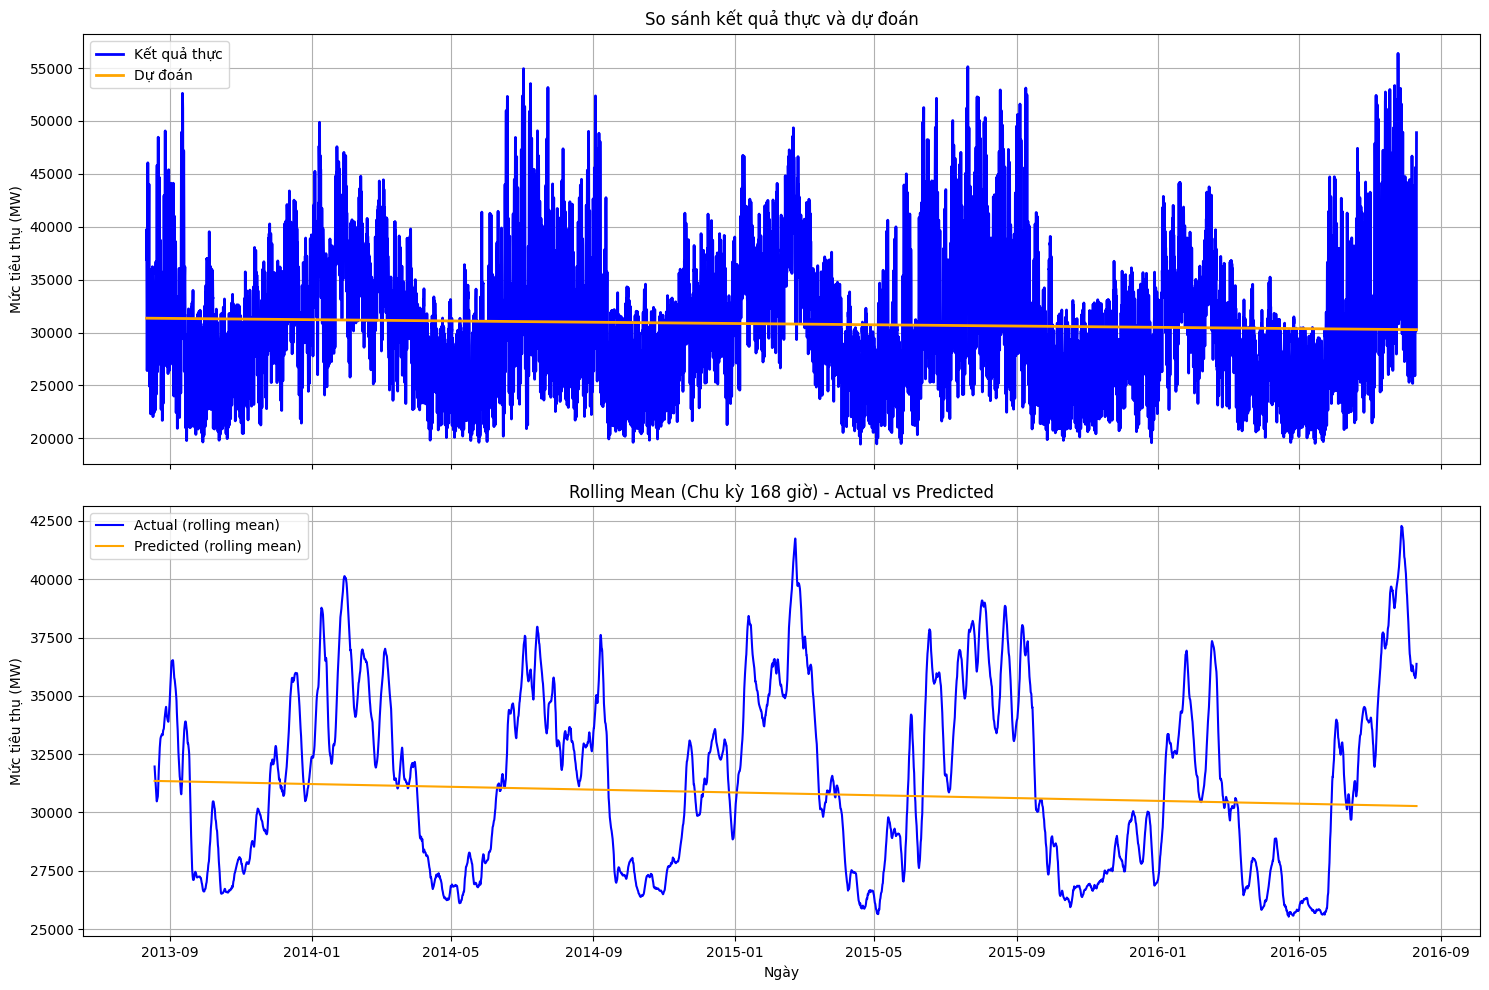

Thông số: yhat
MAE : 2987.00 (~0 nghĩa là tốt hơn)
MAPE: 9.31% (~0 nghĩa là tốt hơn)
MSE : 15557829.11 (~0 nghĩa là tốt hơn)
Pearson's r 0.79 (~1 nghĩa là phản ánh được xu hướng)


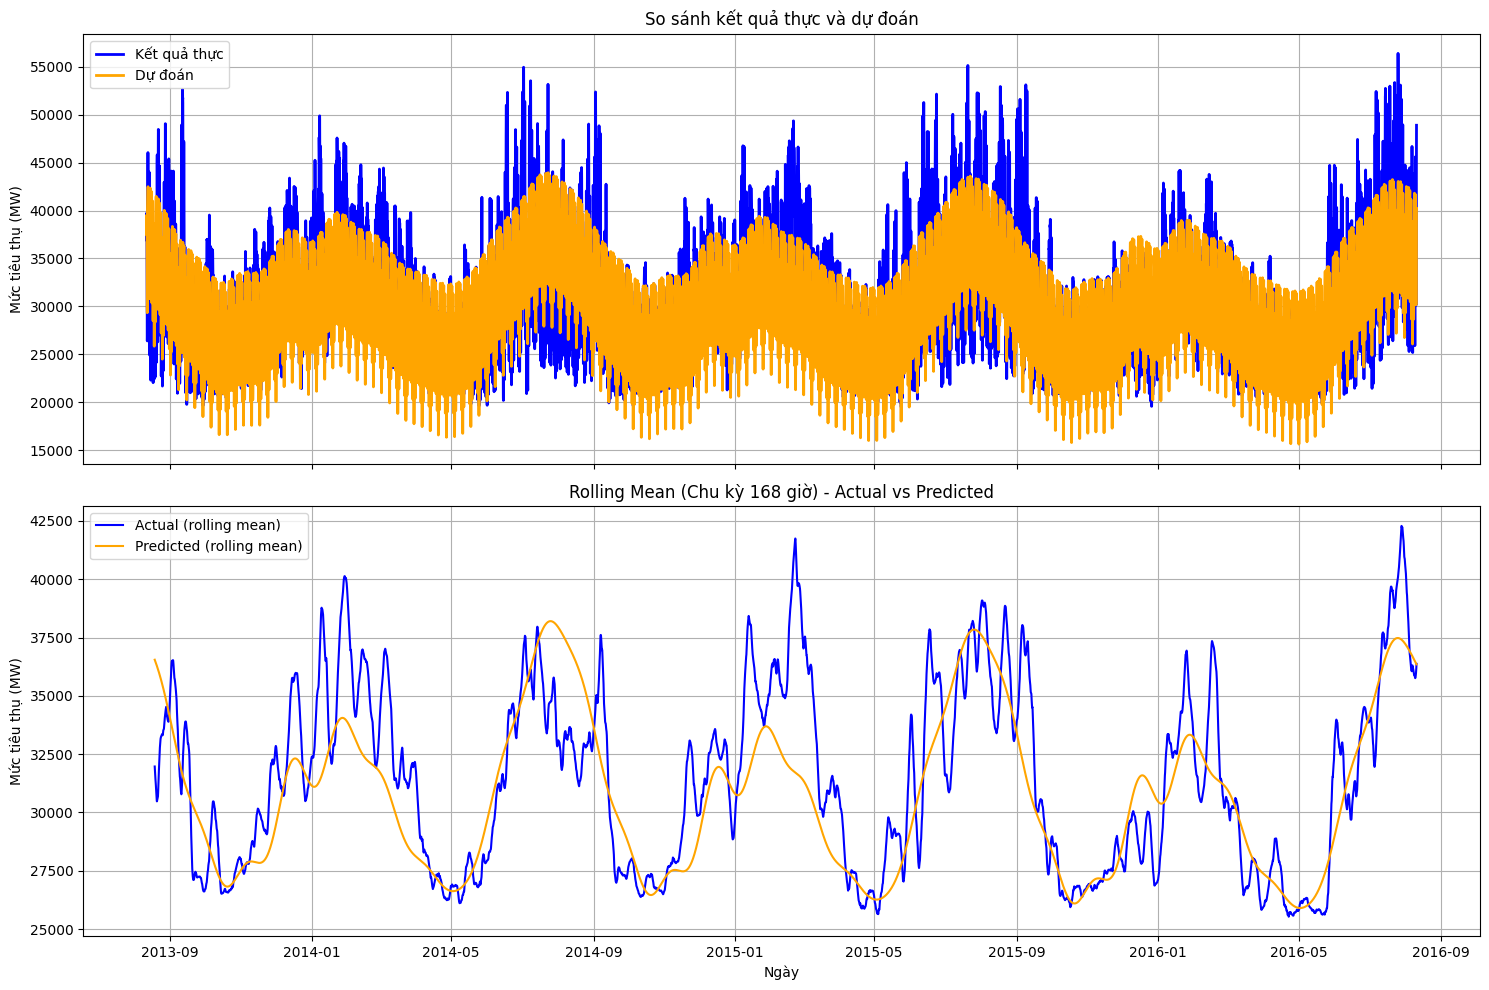

Thông số: daily
MAE : 4175.16 (~0 nghĩa là tốt hơn)
MAPE: 13.00% (~0 nghĩa là tốt hơn)
MSE : 27858368.14 (~0 nghĩa là tốt hơn)
Pearson's r 0.56 (~1 nghĩa là phản ánh được xu hướng)


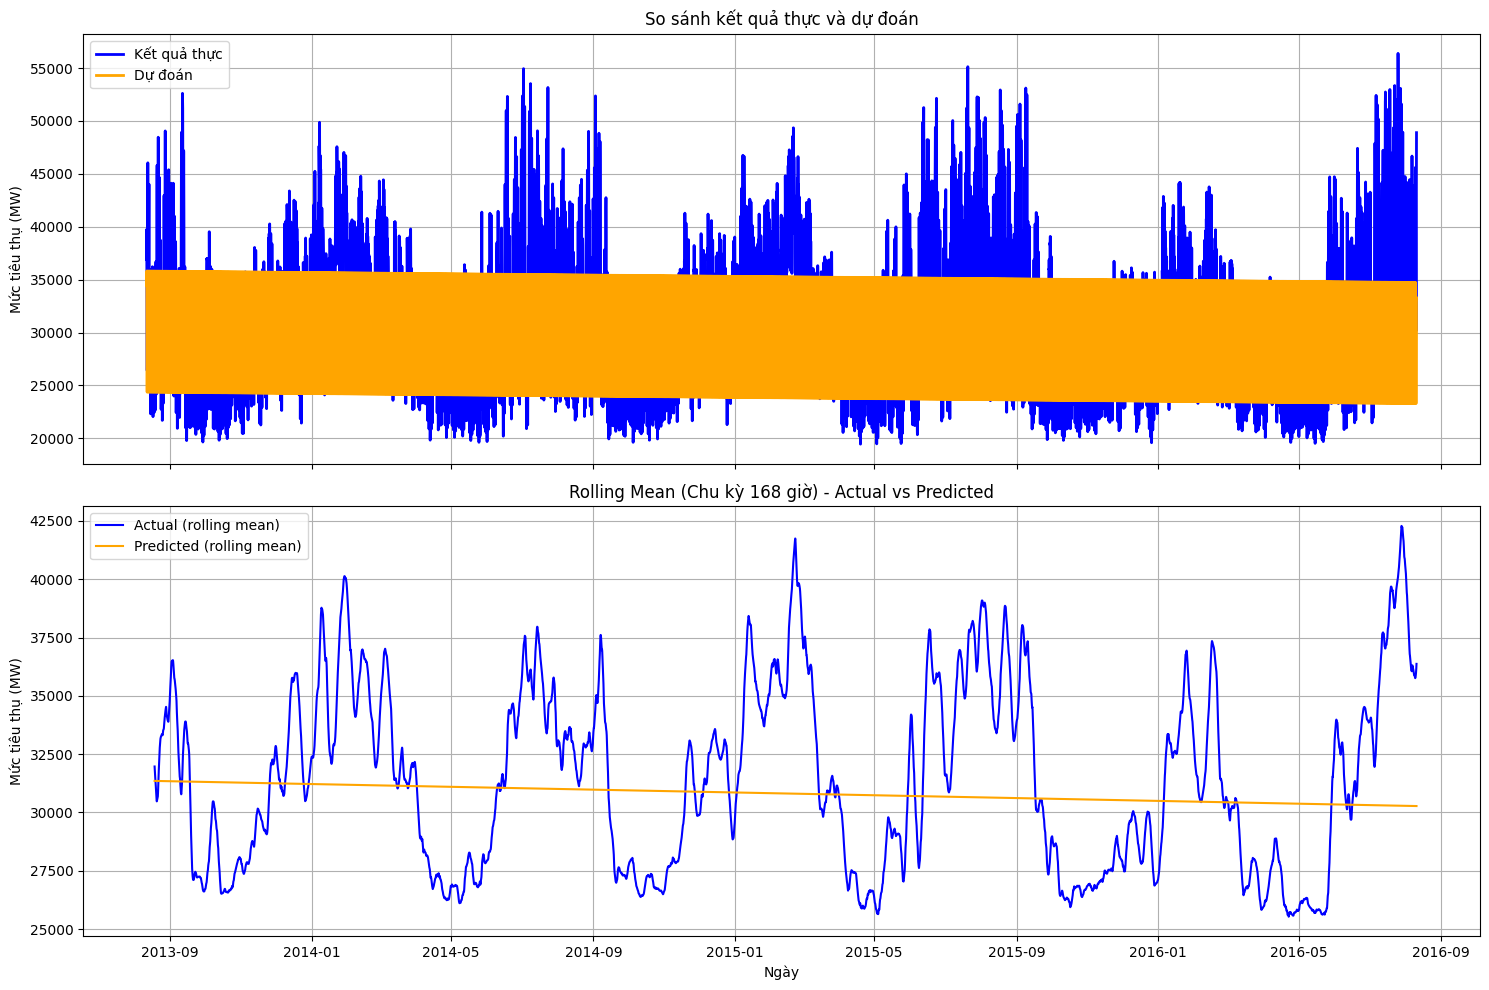

Thông số: weekly
MAE : 4805.52 (~0 nghĩa là tốt hơn)
MAPE: 15.38% (~0 nghĩa là tốt hơn)
MSE : 38077002.53 (~0 nghĩa là tốt hơn)
Pearson's r 0.24 (~1 nghĩa là phản ánh được xu hướng)


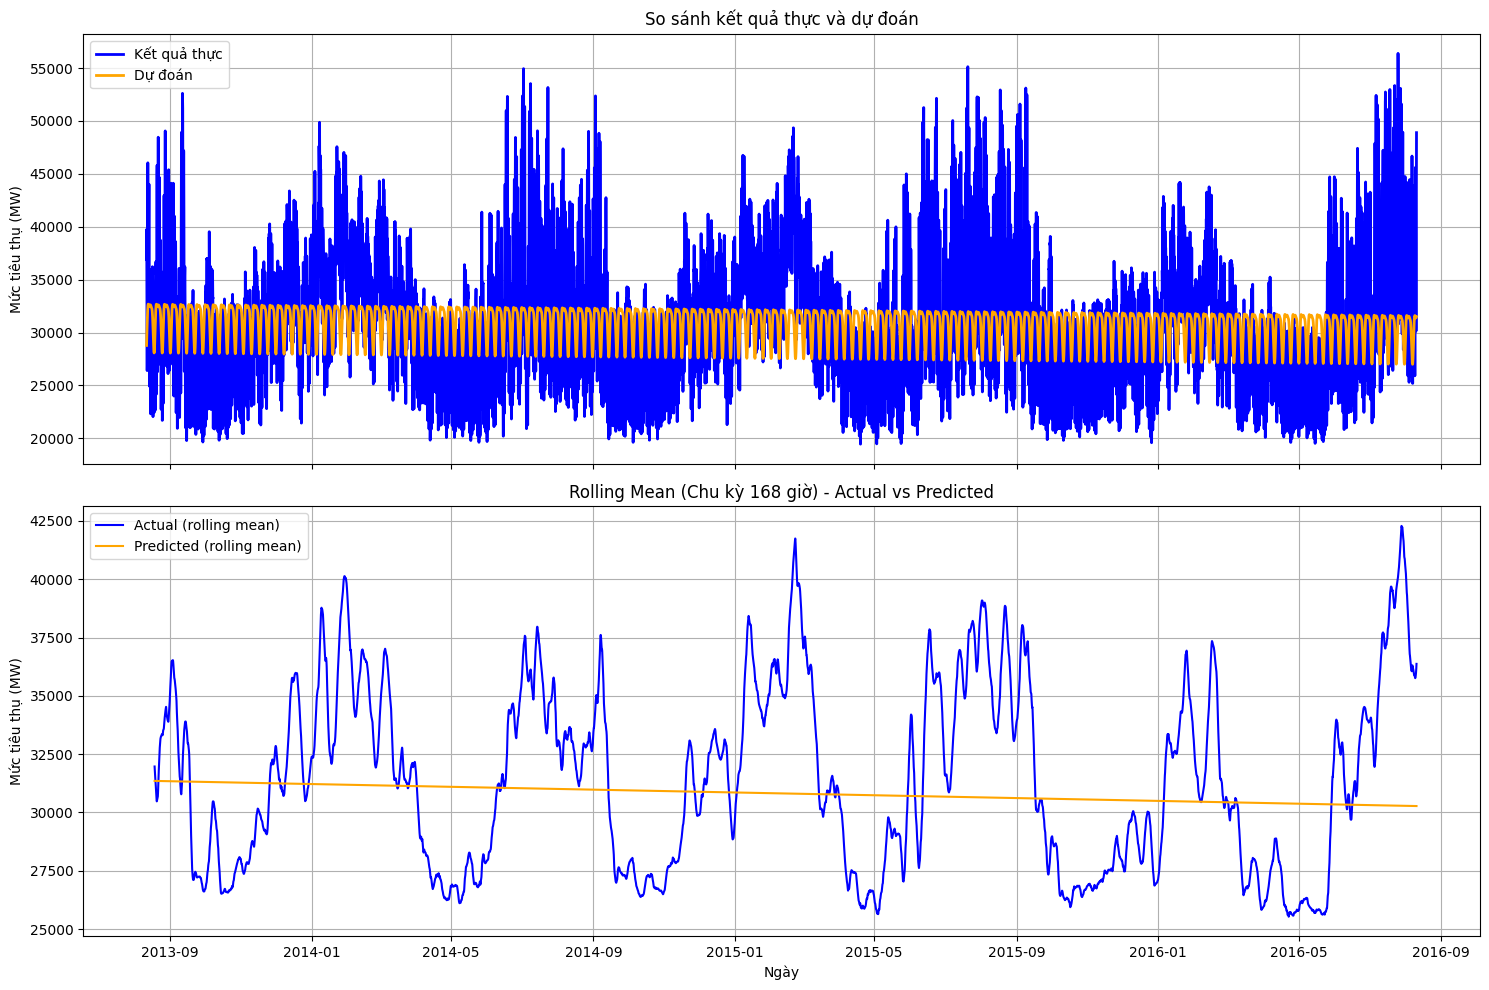

Thông số: yearly
MAE : 4135.17 (~0 nghĩa là tốt hơn)
MAPE: 13.31% (~0 nghĩa là tốt hơn)
MSE : 28090877.91 (~0 nghĩa là tốt hơn)
Pearson's r 0.56 (~1 nghĩa là phản ánh được xu hướng)


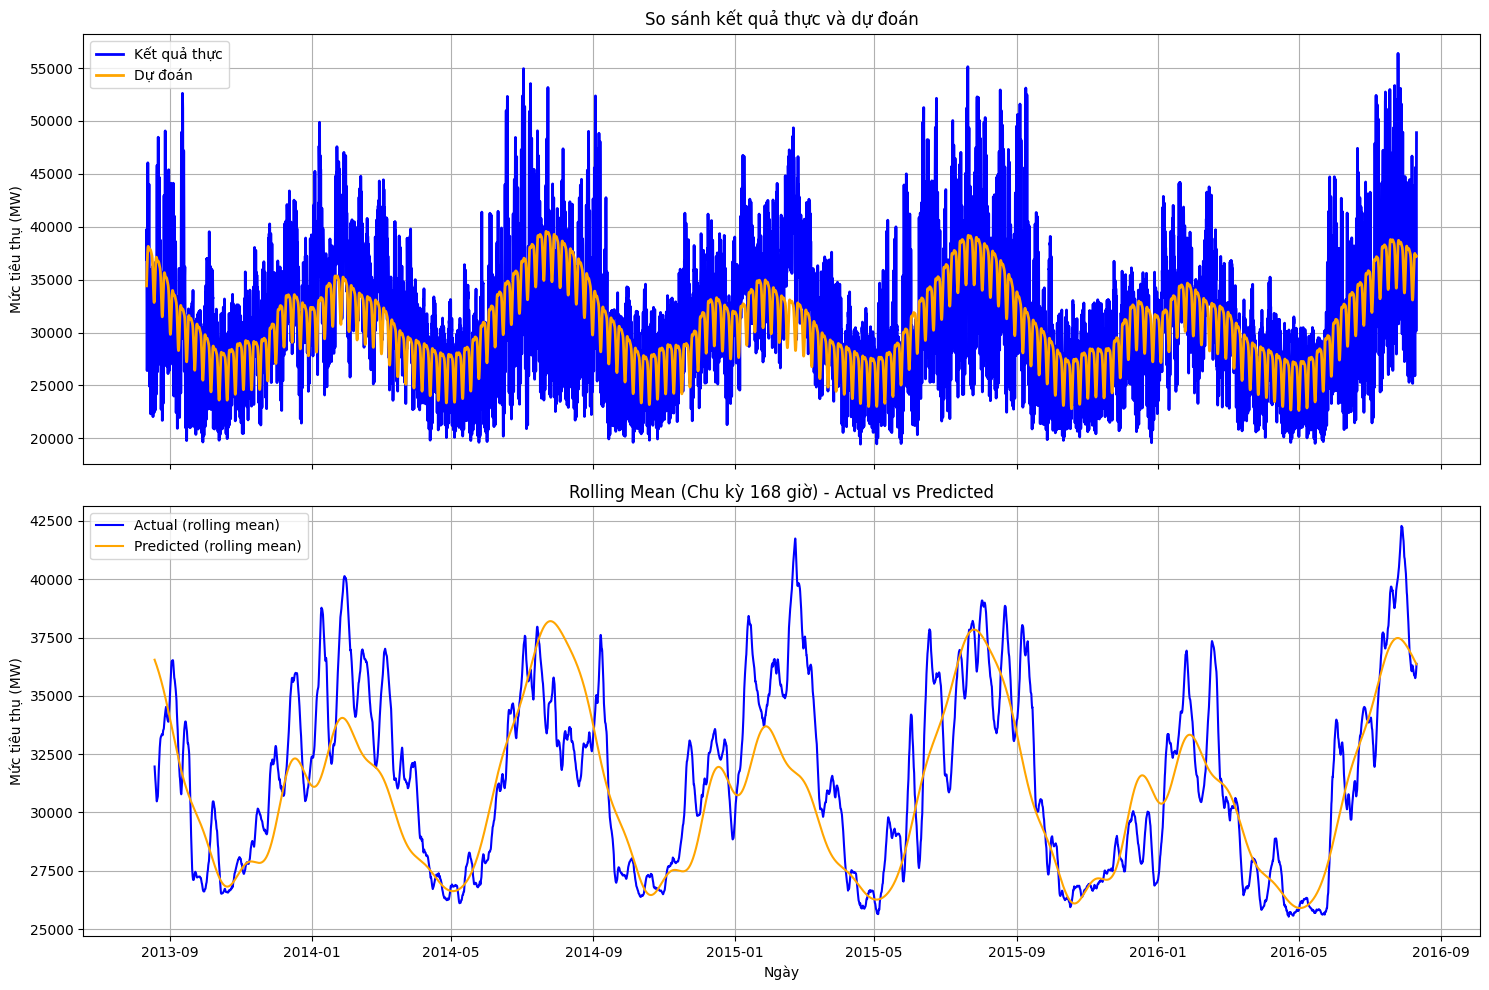

Thông số: additive_terms
MAE : 2987.00 (~0 nghĩa là tốt hơn)
MAPE: 9.31% (~0 nghĩa là tốt hơn)
MSE : 15557829.11 (~0 nghĩa là tốt hơn)
Pearson's r 0.79 (~1 nghĩa là phản ánh được xu hướng)


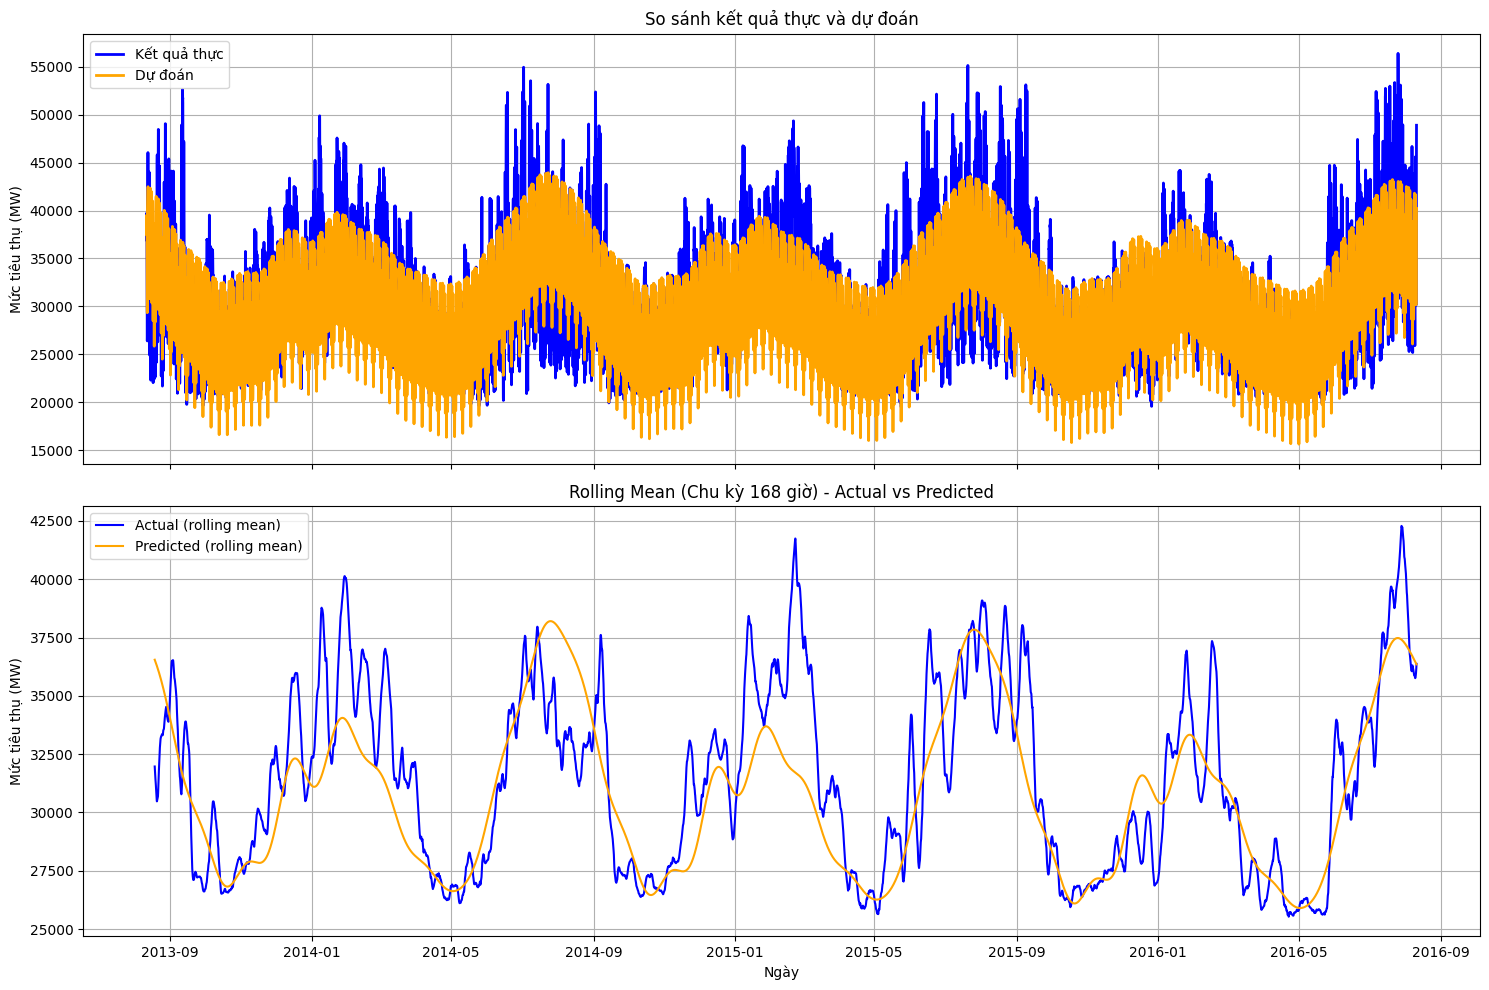

In [14]:
prediction = prophet_predict.set_index('ds').loc[test_data.index]

test_predict = {
        'trend' : prediction['trend'],
        'yhat' : prediction['yhat'],
        'daily' : prediction['daily'] + prediction['trend'],            # Để dễ đối chiếu
        'weekly' : prediction['weekly'] + prediction['trend'],
        'yearly' : prediction['yearly'] + prediction['weekly'] + prediction['trend'],
        'additive_terms' : prediction['additive_terms'] + prediction['trend']
}
y_test = test_data.iloc[:, 0]

zoom = (0., 0.2)       # Khu vực zoom-in của biểu đồ (theo %)

draw_len = test_predict['yhat'].size
start = int(draw_len * zoom[0])
end = int(draw_len * zoom[1])

start = 0
end = 24*365*3

for key in test_predict.keys() :
    print('Thông số: ' + key)
    score_compare(y_test[start:end], test_predict[key][start:end])
    plot_compare(y_test[start:end], test_predict[key][start:end])
    

Với các thông số được đưa ra, việc đơn thuần mô hình Prophet khó có thể dự đoán được kết quả chính xác. Tuy nhiên, ta cũng rút ra được một vài thông tin nổi bật nhất định.
<ul>
    <li>trend: Phản ánh sự thay đổi tổng thể của dữ liệu trong dài hạn.<br>
        Như ta cũng có thể thấy, biểu đồ trend hoàn toàn tuyến tính, mặc dù có một chút xu hướng giảm, nhưng không đáng kể. Ta dự đoán được phần nào xu hướng tiêu thụ điện ổn dịnh, không quá thay đổi qua các năm.</li>
    <li>daily, weekly, yearly: Phản ánh chu kỳ thay đổi trong thời hạn ngày, tháng, năm<br>
        Đều cho thấy tồn tại tính chất chu kỳ rõ ràng trong các khoảng thời gian đó.
</ul>

Mô hình prophet đã bắt được hầu hết đặc tính chu kỳ, mùa vụ của dữ liệu. Đây sẽ là bước đệm để lựa chọn và cải thiện những mô hình phù hợp cho xử lý bài toán này.

# Tham khảo thêm: 

- [Youtube: Rob Mulla's Forecasting with the FB Prophet Model](https://www.youtube.com/watch?v=j0eioK5edqg)

# Thử nghiệm:
<p>Như ta đã biết, prophet model sẵn cung cấp thông số yhat để dự đoán kết quả cuối, tuy nhiên, việc yhat có thực sự được cân đối đẹp hay không thì vẫn còn là một dấu hỏi. Nên phần này muốn thử cải thiện dự đoán thông qua các thống số Prophet cung cấp.</p>

<p>Phương pháp sử dụng đơn giản là Linear Regression</p>

<h4><strong>Kết quả:</strong></h4>
<p>Cột yhat được tạo ra bởi linear regression toàn bộ các cột còn lại, tỉ lệ giống nhau tới 99.74%, không phải bàn.</p>

In [21]:
train_X = prophet_train_predict.set_index('ds')[feature_columns]
train_y = train_data.iloc[:, 0]

test_X = prophet_predict.set_index('ds')[feature_columns]
test_y = test_data.iloc[:, 0]

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Linear Regression model bằng Keras
model = models.Sequential([
    layers.Input(shape=(len(train_X.columns),)),  # số lượng feature
    layers.Dense(1, activation='linear')       # đầu ra dự đoán y
])

# Compile
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [49]:

model.fit(train_X, train_y, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 94328448.0000 - mae: 6157.3901 - mape: 18.4709
Epoch 2/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12175652.0000 - mae: 2607.4326 - mape: 7.9597
Epoch 3/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12242142.0000 - mae: 2612.8896 - mape: 7.9714
Epoch 4/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12190333.0000 - mae: 2614.7771 - mape: 7.9877
Epoch 5/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12206274.0000 - mae: 2608.7686 - mape: 7.9572
Epoch 6/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12207028.0000 - mae: 2608.1338 - mape: 7.9625
Epoch 7/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12167167.0000 - mae: 2603.0884 - mape: 7.9476
Epoch 8/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12152260.0000 - mae: 2609.0508 - mape: 7.9718
Epoch 9/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 12138102.0000 - mae: 2606.4751 - mape: 7.9600
Epoch 10/10
6361/6361 ━━━━━

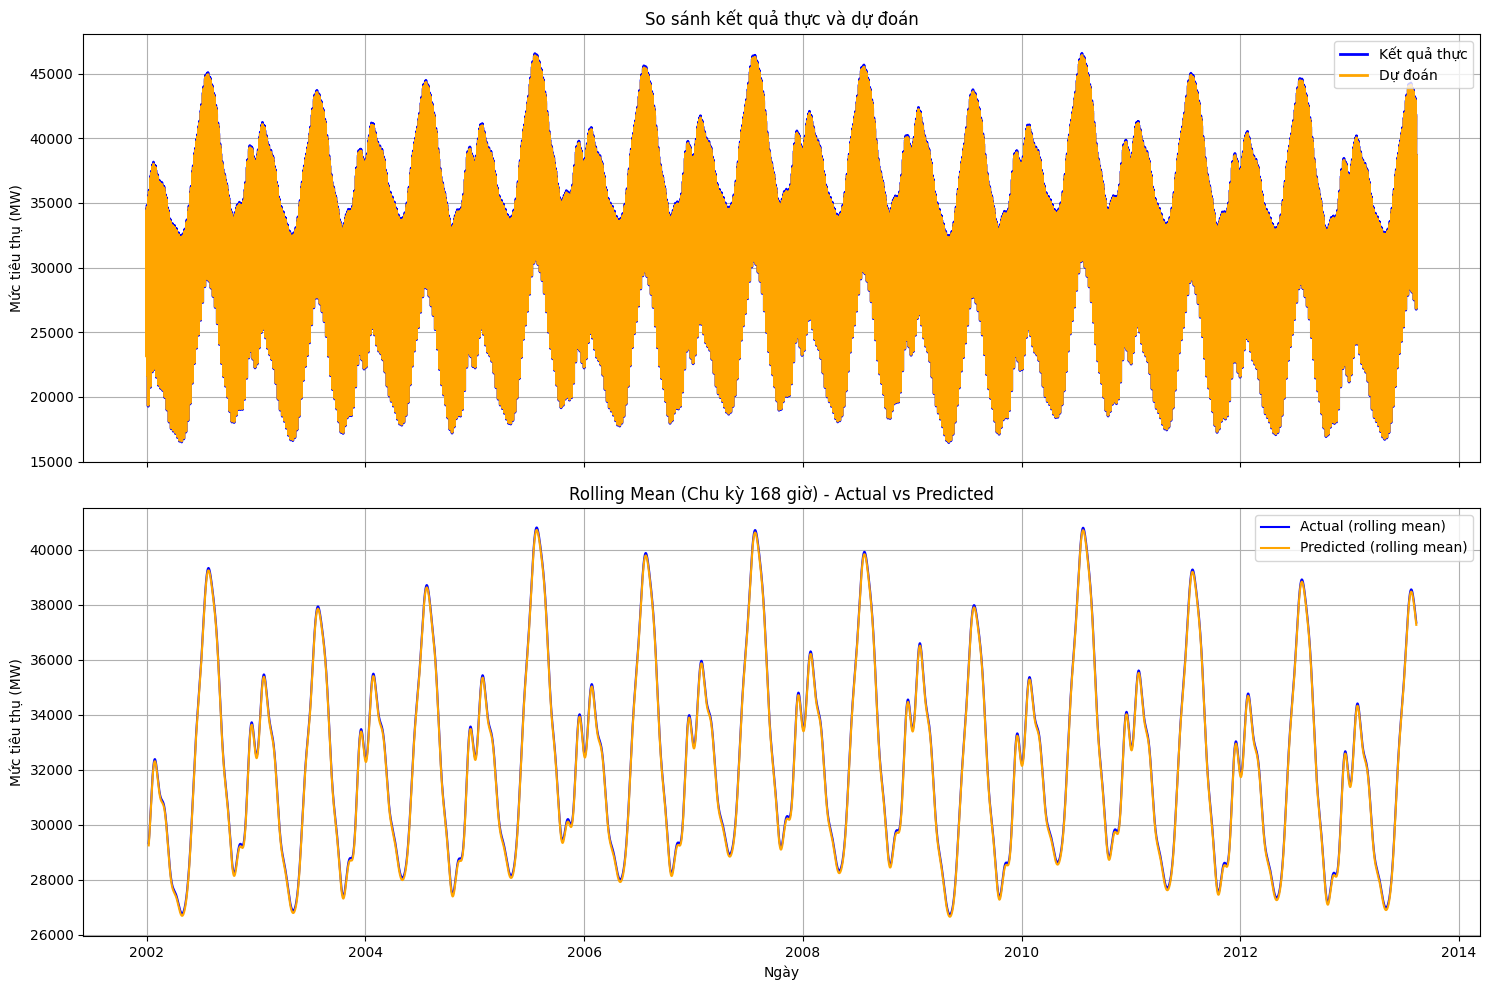

MAE : 94.91 (~0 nghĩa là tốt hơn)
MAPE: 0.29% (~0 nghĩa là tốt hơn)
MSE : 11497.71 (~0 nghĩa là tốt hơn)
Pearson's r 1.00 (~1 nghĩa là phản ánh được xu hướng)


In [57]:
# array_train_predict = model.predict(train_X)

# train_predict = pd.DataFrame(array_train_predict, index=train_X.index, columns=['result'])['result']

plot_compare(prophet_train_predict.set_index('ds')['yhat'], train_predict)
score_compare(prophet_train_predict.set_index('ds')['yhat'], train_predict)

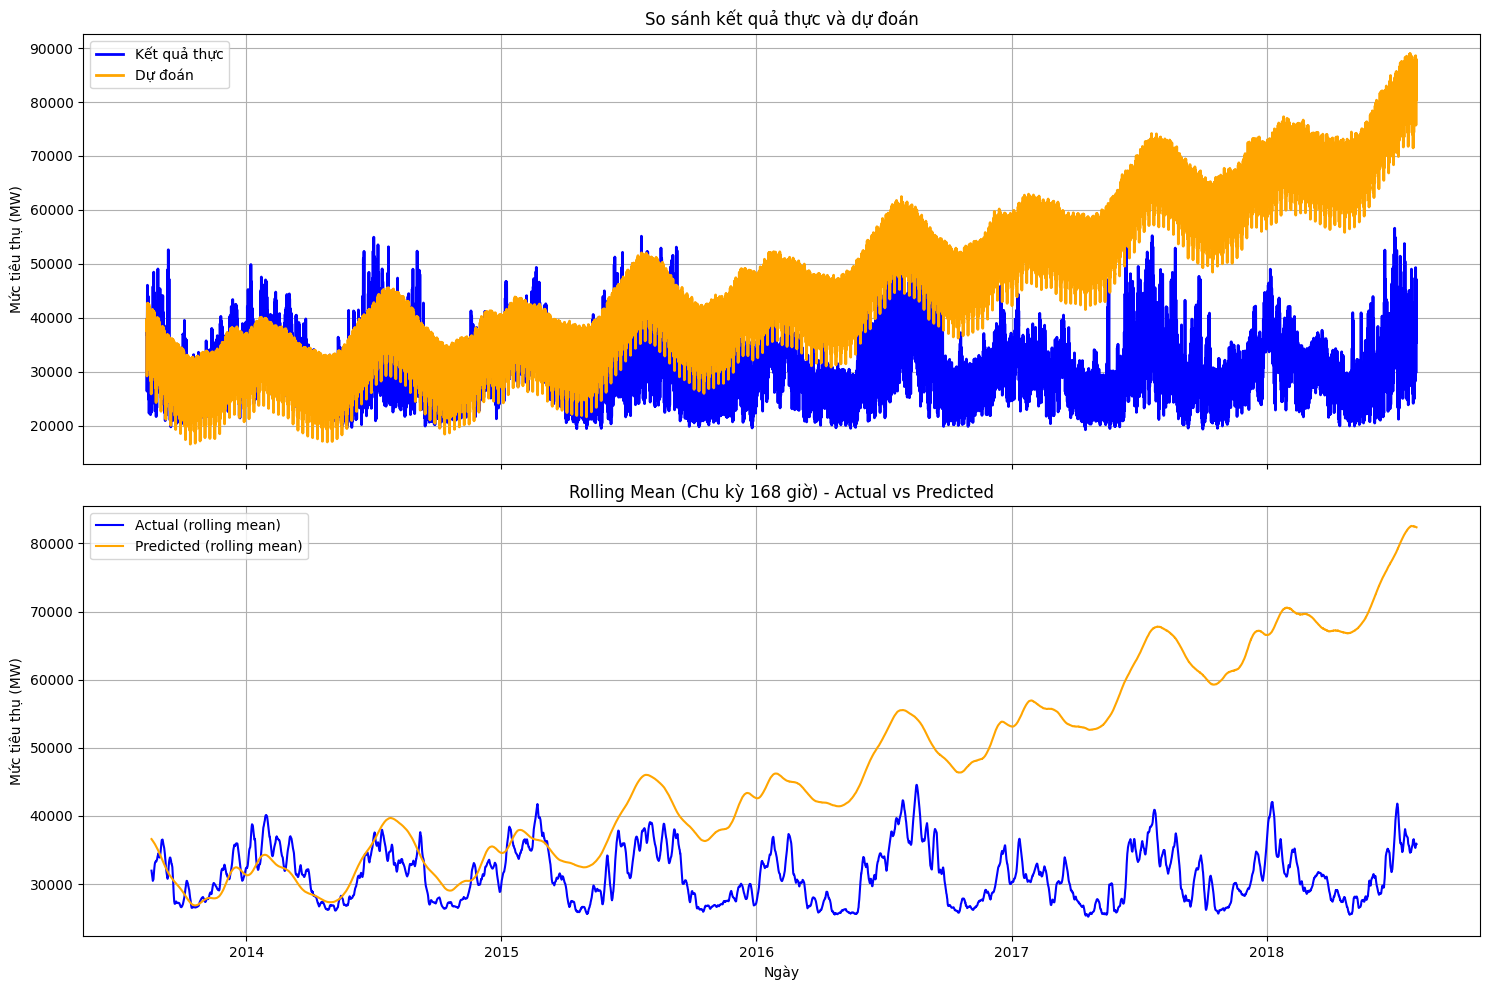

MAE : 16279.38 (~0 nghĩa là tốt hơn)
MAPE: 54.87% (~0 nghĩa là tốt hơn)
MSE : 445508120.67 (~0 nghĩa là tốt hơn)
Pearson's r 0.27 (~1 nghĩa là phản ánh được xu hướng)


In [52]:
# array_test_predict = model.predict(test_X)
# test_predict = pd.DataFrame(array_test_predict, index=test_X.index, columns=['result'])['result']

zoom = [0, 0.5]

start = int(test_X.size * zoom[0])
end = int(test_X.size * zoom[1])

# start = 0
# end = 7 * 24 * 5

plot_compare(test_y[start:end,], test_predict[start:end,])
score_compare(test_y[start:end,], test_predict[start:end,])